In [34]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nengo
import time
palette = sns.color_palette("tab10")
sns.set_palette(palette)
sns.set(context='notebook', style='white')

In [6]:
def load_values(load=False, monkeys=['V', 'W'], sessions=[0,1,2,3], blocks=range(1,25)):
    if load:
        nef_values = pd.read_pickle("data/nef_values.pkl")
    else:
        emp = pd.read_pickle("data/empirical.pkl")
        nef_dfs = []
        rl_dfs = []
        for monkey in monkeys:
            for session in sessions:
                for block in blocks:
                # for block in emp.query("monkey==@monkey & session==@session")['block'].unique():
                    for trial in emp.query("monkey==@monkey & session==@session & block==@block")['trial'].unique():
                        file = f"monkey{monkey}_session{session}_block{block}_trial{trial}"
                        nef_dfs.append(pd.read_pickle(f'data/nef/{file}_values.pkl'))
        nef_values = pd.concat(nef_dfs, ignore_index=True)
        nef_values.to_pickle("data/nef_values.pkl")
    return nef_values

In [21]:
nef_values = load_values(False, monkeys=['V'], sessions=[1], blocks=[1,2,3,4,22,23,24])

In [22]:
nef_values

,monkey,session,block,trial,block_type,pre,post,va,vb,vl,vr,w,al,ar,clet,cloc,rew,acc
0,V,1,1,1,what,1,-1,0.004612,-0.002394,0.002688,0.008275,0.493539,-0.031746,0.067777,A,right,-1,0
1,V,1,1,2,what,2,-1,-0.018062,-0.120078,0.006680,-0.198608,0.522548,-0.064017,-0.098777,B,left,1,1
2,V,1,1,3,what,3,-1,0.132284,-0.091249,0.175695,-0.153768,0.520933,0.120365,-0.070529,B,left,1,1
3,V,1,1,4,what,4,-1,-0.075747,0.290101,0.313918,-0.128956,0.517040,0.106600,0.073646,A,left,-1,0
4,V,1,1,5,what,5,-1,-0.182309,0.159416,0.112824,-0.048656,0.488180,-0.084640,0.080722,B,right,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555,V,1,24,76,where,-1,33,0.096571,0.170293,0.788256,0.040013,0.098396,0.731123,0.043773,B,left,1,1
556,V,1,24,77,where,-1,34,0.119815,0.197421,0.814019,0.030127,0.096464,0.764362,0.032532,A,left,-1,1
557,V,1,24,78,where,-1,35,-0.020452,0.089676,0.633854,0.034039,0.094265,0.553105,0.034807,A,left,1,1
558,V,1,24,79,where,-1,36,0.013629,0.124500,0.716299,0.023960,0.092095,0.644318,0.026549,B,left,1,1


## Confirm learning

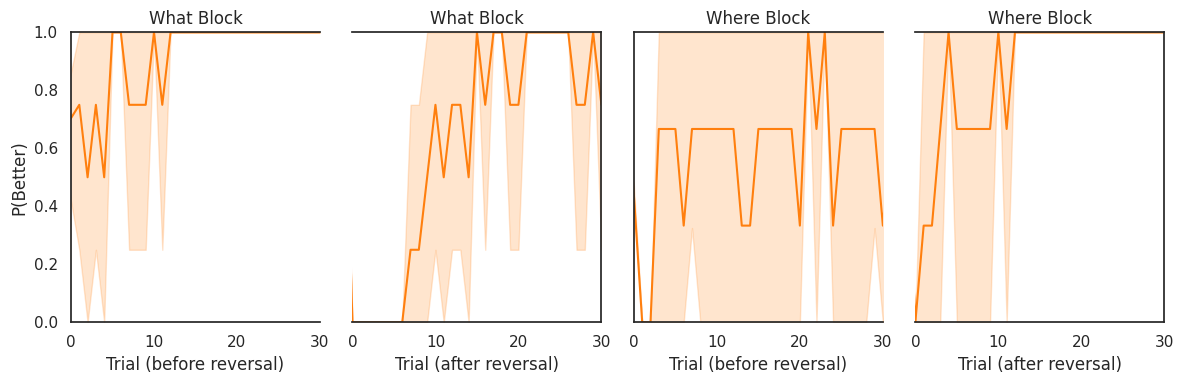

In [35]:
fig, axes = plt.subplots(nrows=1, ncols=4, sharey=True, sharex=True, figsize=(12, 4))
sns.lineplot(nef_values.query("block_type=='what'"), x='pre', y='acc', color=palette[1], ax=axes[0])
sns.lineplot(nef_values.query("block_type=='what'"), x='post', y='acc', color=palette[1], ax=axes[1])
sns.lineplot(nef_values.query("block_type=='where'"), x='pre', y='acc', color=palette[1], ax=axes[2])
sns.lineplot(nef_values.query("block_type=='where'"), x='post', y='acc', color=palette[1], ax=axes[3])
axes[0].set(ylabel="P(Better)", xlabel='Trial (before reversal)', title='What Block', xlim=(0, 30), ylim=(0,1))
axes[1].set(xlabel='Trial (after reversal)', title='What Block')
axes[2].set(xlabel='Trial (before reversal)', title='Where Block')
axes[3].set(xlabel='Trial (after reversal)', title='Where Block')
axes[0].spines['right'].set_visible(False)
axes[1].spines['left'].set_visible(False)
axes[2].spines['right'].set_visible(False)
axes[3].spines['left'].set_visible(False)
fig.tight_layout()

## Compute Differential Response

In [23]:
def add_DR(data):
    dfs = []
    columns = ['monkey', 'session', 'block', 'block_type', 'DR_let', 'DR_loc']
    for monkey in data['monkey'].unique():
        for session in data.query("monkey==@monkey")['session'].unique():
            for block in data.query("monkey==@monkey & session==@session")['block'].unique():
                subdata = data.query("monkey==@monkey & session==@session & block==@block")
                block_type = subdata['block_type'].values[0]
                n_stay_let_win = 0
                n_stay_let_lose = 0
                n_stay_loc_win = 0
                n_stay_loc_lose = 0
                for trial in subdata['trial'].unique()[1:]:
                    reward = subdata.query("trial==@trial")['rew'].values[0]
                    past_trial = trial - 1
                    past_let = subdata.query("trial==@past_trial")['clet'].values[0]
                    current_let = subdata.query("trial==@trial")['clet'].values[0]
                    past_loc = subdata.query("trial==@past_trial")['cloc'].values[0]
                    current_loc = subdata.query("trial==@trial")['cloc'].values[0]
                    if current_let==past_let:
                        if reward==1:
                            n_stay_let_win += 1
                        else:
                            n_stay_let_lose += 1
                    if current_loc==past_loc:
                        if reward==1:
                            n_stay_loc_win += 1
                        else:
                            n_stay_loc_lose += 1
                if n_stay_let_win + n_stay_let_lose > 0:
                    p_stay_let_win = n_stay_let_win / (n_stay_let_win + n_stay_let_lose)
                    p_stay_let_lose = n_stay_let_lose / (n_stay_let_win + n_stay_let_lose)
                    DR_let = p_stay_let_win - p_stay_let_lose
                else:
                    DR_let = None
                if n_stay_loc_win + n_stay_loc_lose > 0:
                    p_stay_loc_win = n_stay_loc_win / (n_stay_loc_win + n_stay_loc_lose)
                    p_stay_loc_lose = n_stay_loc_lose / (n_stay_loc_win + n_stay_loc_lose)
                    DR_loc = p_stay_loc_win - p_stay_loc_lose
                else:
                    DR_loc = None
                dfs.append(pd.DataFrame([[monkey, session, block, block_type, DR_let, DR_loc]], columns=columns))
    dr_data = pd.concat(dfs, ignore_index=True)
    return dr_data

In [24]:
nef_dr = add_DR(nef_values)

In [25]:
nef_dr

,monkey,session,block,block_type,DR_let,DR_loc
0,V,1,1,what,0.287671,0.150000
1,V,1,2,what,0.194444,0.024390
2,V,1,3,what,0.169231,0.087719
3,V,1,4,what,0.378378,0.380952
4,V,1,22,where,0.272727,0.362319
5,V,1,23,where,-0.061224,0.106383
6,V,1,24,where,0.392857,0.368421


<Axes: xlabel='DR_let', ylabel='DR_loc'>

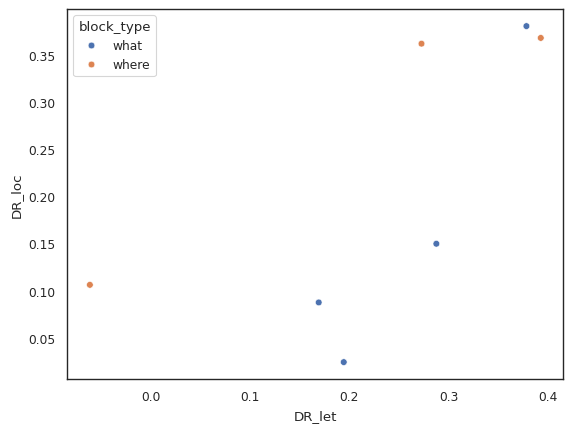

In [28]:
fig, ax = plt.subplots()
sns.scatterplot(data=nef_dr, x='DR_let', y='DR_loc', hue='block_type')